<a href="https://colab.research.google.com/github/Shreyas-Hegde10/MNIST-Deep-Learning/blob/main/Image_Recognition_Using_CNNs_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Necessary Libraries and Loading Dataset


In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import optuna

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
random_seed = 42
torch.manual_seed(random_seed);

In [3]:
# Downloading the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,'.')

100%|██████████| 135107811/135107811 [00:04<00:00, 30653090.92it/s]


In [4]:
# Extracting dataset from the archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [5]:
# Checking folders
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir+ "/train")
print(classes)

['test', 'train']
['dog', 'airplane', 'cat', 'bird', 'frog', 'ship', 'deer', 'truck', 'horse', 'automobile']


In [6]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
img,label = dataset[0]
print(img.shape,label)
print(img)

torch.Size([3, 32, 32]) 0
tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235

In [7]:
# Creating a helper function to display images
def show_image(img,label):
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1,2,0))

Label:  airplane (0)


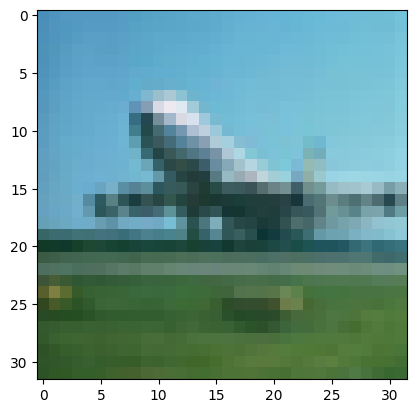

In [8]:
show_image(*dataset[100])

Creating Training, Validation, & Test Sets

In [9]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = ImageFolder(data_dir+'/test', transform=ToTensor())
print(len(train_ds), len(val_ds), len(test_ds))

45000 5000 10000


In [10]:
# Initializing dataloaders
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# Looking at a batch of images
def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

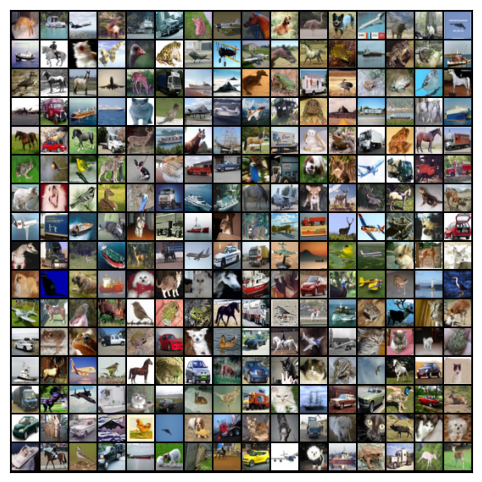

In [12]:
show_batch(val_dl)

Defining the Model

In [80]:
# Creating a class that contains helper methods fpr training and validation
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss':epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

  def epoch_end_1(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

  # Test loss and accuracy method
  def test_step(self, batch):
    images, labels = batch
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'test_loss': loss, 'test_acc': acc}

  # Method used for combining batch losses & accuracies into epoch losses/accuracies for the test set
  def test_epoch_end(self, outputs):
    batch_losses = [x['test_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['test_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

  # Method used for format test losses and accuracies
  def epoch_endtest(self, epoch, result):
    print("Epoch [{}], test_loss: {:.4f}, test_acc: {:.4f}".format(epoch, result['test_loss'], result['test_acc']))


# Accuracy function
def accuracy(outputs,labels):
  _,preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [81]:
class Cifar10Model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        # Input: 3 * 32 * 32
        nn.Conv2d(3,32, kernel_size=3, padding=1),
        # Output: 32 * 32 * 32
        nn.ReLU(),
        # Output: 32 * 32 * 32
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        # Output: 64 * 32 * 32
        nn.ReLU(),
        # Output: 64 * 32 * 32
        nn.MaxPool2d(2,2), #Output: 64 * 16 * 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 * 8 * 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 * 4 * 4

        nn.Flatten(),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

  def forward(self, xb):
        return self.network(xb)


In [15]:
model = Cifar10Model()
model

Cifar10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [16]:
# Verifying whether the model produces 10 outputs for each image
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]: ', out[0])
  break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]:  tensor([-0.0200, -0.0278,  0.0383, -0.0335, -0.0071,  0.0407,  0.0165,  0.0054,
        -0.0288,  0.0438], grad_fn=<SelectBackward0>)


GPU Helper Functions

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
# Checking if the notebook is running on a GPU(yes it is)
device = get_default_device()
device

device(type='cuda')

In [68]:
# Moving dataloaders and model to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

Training the Model

In [47]:
# Function used to generate validation accuracies and losses
def evaluate(model, val_loader):
  model.eval()  # Set model to evaluation mode
  outputs = []

  # Iterate through the validation dataset and accumulate results
  with torch.no_grad():  # Disable gradient computation since we're only doing evaluation
      for batch in val_loader:
          output = model.validation_step(batch)
          outputs.append(output)  # Append validation results for each batch

  return model.validation_epoch_end(outputs)  # Aggregate the results over all batches

# Function used to train and display train losses, validation accuracies/losses
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model_gpu = to_device(Cifar10Model(), device) # Transferring model to GPU

In [22]:
history1 = fit(10,0.001,model_gpu, train_dl, val_dl, opt_func = torch.optim.Adam)

Epoch [0], train_loss: 1.8103, val_loss: 1.5607, val_acc: 0.4288
Epoch [1], train_loss: 1.2980, val_loss: 1.1987, val_acc: 0.5754
Epoch [2], train_loss: 1.0168, val_loss: 0.9804, val_acc: 0.6513
Epoch [3], train_loss: 0.8375, val_loss: 0.8323, val_acc: 0.6995
Epoch [4], train_loss: 0.7043, val_loss: 0.7852, val_acc: 0.7360
Epoch [5], train_loss: 0.5862, val_loss: 0.7382, val_acc: 0.7511
Epoch [6], train_loss: 0.4886, val_loss: 0.7446, val_acc: 0.7520
Epoch [7], train_loss: 0.4038, val_loss: 0.7448, val_acc: 0.7638
Epoch [8], train_loss: 0.3235, val_loss: 0.8124, val_acc: 0.7522
Epoch [9], train_loss: 0.2549, val_loss: 0.9001, val_acc: 0.7650


In [23]:
history2 = fit(10,0.001,model_gpu, train_dl, val_dl, opt_func = torch.optim.Adam)

Epoch [0], train_loss: 0.1873, val_loss: 1.0879, val_acc: 0.7523
Epoch [1], train_loss: 0.1491, val_loss: 1.2178, val_acc: 0.7581
Epoch [2], train_loss: 0.1187, val_loss: 1.1426, val_acc: 0.7510
Epoch [3], train_loss: 0.1173, val_loss: 1.2000, val_acc: 0.7465
Epoch [4], train_loss: 0.1031, val_loss: 1.3318, val_acc: 0.7582
Epoch [5], train_loss: 0.0899, val_loss: 1.4568, val_acc: 0.7541
Epoch [6], train_loss: 0.0864, val_loss: 1.4498, val_acc: 0.7482
Epoch [7], train_loss: 0.0843, val_loss: 1.3605, val_acc: 0.7569
Epoch [8], train_loss: 0.0715, val_loss: 1.5686, val_acc: 0.7500
Epoch [9], train_loss: 0.0716, val_loss: 1.5448, val_acc: 0.7526


In [24]:
model_gpu1 = to_device(Cifar10Model(), device) # Transferring model to GPU

In [25]:
history3 = fit(10,0.001,model_gpu, train_dl, val_dl)

Epoch [0], train_loss: 0.0339, val_loss: 1.4502, val_acc: 0.7599
Epoch [1], train_loss: 0.0223, val_loss: 1.4391, val_acc: 0.7634
Epoch [2], train_loss: 0.0186, val_loss: 1.4454, val_acc: 0.7632
Epoch [3], train_loss: 0.0162, val_loss: 1.4451, val_acc: 0.7672
Epoch [4], train_loss: 0.0144, val_loss: 1.4502, val_acc: 0.7676
Epoch [5], train_loss: 0.0131, val_loss: 1.4576, val_acc: 0.7672
Epoch [6], train_loss: 0.0120, val_loss: 1.4630, val_acc: 0.7699
Epoch [7], train_loss: 0.0110, val_loss: 1.4753, val_acc: 0.7703
Epoch [8], train_loss: 0.0102, val_loss: 1.4762, val_acc: 0.7694
Epoch [9], train_loss: 0.0096, val_loss: 1.4838, val_acc: 0.7690


In [26]:
history4 = fit(10,0.001,model_gpu, train_dl, val_dl)

Epoch [0], train_loss: 0.0090, val_loss: 1.4946, val_acc: 0.7713
Epoch [1], train_loss: 0.0085, val_loss: 1.5010, val_acc: 0.7715
Epoch [2], train_loss: 0.0080, val_loss: 1.5075, val_acc: 0.7709
Epoch [3], train_loss: 0.0075, val_loss: 1.5136, val_acc: 0.7711
Epoch [4], train_loss: 0.0071, val_loss: 1.5199, val_acc: 0.7707
Epoch [5], train_loss: 0.0068, val_loss: 1.5269, val_acc: 0.7723
Epoch [6], train_loss: 0.0065, val_loss: 1.5331, val_acc: 0.7717
Epoch [7], train_loss: 0.0062, val_loss: 1.5404, val_acc: 0.7713
Epoch [8], train_loss: 0.0059, val_loss: 1.5465, val_acc: 0.7717
Epoch [9], train_loss: 0.0057, val_loss: 1.5510, val_acc: 0.7711


In [48]:
def objective(trial):
    # Define search space
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    tuning_model = to_device(Cifar10Model(),device)

    # Set the optimizer based on the trial suggestion
    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(tuning_model.parameters(), lr=lr)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(tuning_model.parameters(), lr=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = torch.optim.RMSprop(tuning_model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()  # Define loss function

    # Dataloaders
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=256, num_workers=4, pin_memory=True)
    train_dl = DeviceDataLoader(train_loader, device)
    val_dl = DeviceDataLoader(val_loader, device)


    num_epochs = 5
    history = []
    for epoch in range(num_epochs):
        for batch in train_dl:

             # Training Loop
            loss = tuning_model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation Stage
        tuning_model.eval()  # Set model to evaluation mode
        result = evaluate(tuning_model, val_dl)

        # Report the validation accuracy to Optuna for this epoch
        trial.report(result['val_acc'], epoch)

    # Return the validation accuracy of the last epoch for optimization
    return result['val_acc']



In [58]:
# Create a study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Number of trials

# Get the best trial
best_trial = study.best_trial

# Print the best hyperparameters, best accuracy, and trial number
print(f"Best hyperparameters: {best_trial.params}")
print(f"Best test accuracy: {best_trial.value:.4f}")
print(f"Trial number with best test accuracy: {best_trial.number}")

[I 2024-09-30 00:08:16,880] A new study created in memory with name: no-name-95d4dc5f-a289-42e3-a5ab-1882ca4fa744
<ipython-input-48-04a5f83a8917>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-09-30 00:09:39,889] Trial 0 finished with value: 0.09906939417123795 and parameters: {'lr': 0.011574570633529407, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.09906939417123795.
[I 2024-09-30 00:11:03,216] Trial 1 finished with value: 0.09906939417123795 and parameters: {'lr': 0.000872849419218496, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.09906939417123795.
[I 2024-09-30 00:12:27,277] Trial 2 finished with value: 0.09523207694292068 and parameters: {'lr': 0.029183353994220014, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.09906939417123795.
[I 2024-09-3

Best hyperparameters: {'lr': 0.0006747328370954377, 'optimizer': 'rmsprop'}
Best test accuracy: 0.7031
Trial number with best test accuracy: 6


In [50]:
best_model = Cifar10Model()
best_model = to_device(best_model, device)

In [52]:
history_a1 = fit(10,0.0004896016583477484,best_model, train_dl, val_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 2.0238, val_loss: 1.6099, val_acc: 0.4019
Epoch [1], train_loss: 1.4823, val_loss: 1.3194, val_acc: 0.5198
Epoch [2], train_loss: 1.2208, val_loss: 1.1200, val_acc: 0.6001
Epoch [3], train_loss: 1.0036, val_loss: 1.0159, val_acc: 0.6425
Epoch [4], train_loss: 0.8409, val_loss: 0.9867, val_acc: 0.6586
Epoch [5], train_loss: 0.7060, val_loss: 0.8474, val_acc: 0.7064
Epoch [6], train_loss: 0.5794, val_loss: 0.8555, val_acc: 0.7318
Epoch [7], train_loss: 0.4692, val_loss: 0.8167, val_acc: 0.7399
Epoch [8], train_loss: 0.3532, val_loss: 0.7612, val_acc: 0.7700
Epoch [9], train_loss: 0.2586, val_loss: 1.2214, val_acc: 0.6868


In [53]:
history_a2 = fit(10,0.0004896016583477484,best_model, train_dl, val_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.3909, val_loss: 0.9147, val_acc: 0.7568
Epoch [1], train_loss: 0.1322, val_loss: 1.1167, val_acc: 0.7483
Epoch [2], train_loss: 0.1047, val_loss: 1.5766, val_acc: 0.7329
Epoch [3], train_loss: 0.0907, val_loss: 1.2198, val_acc: 0.7694
Epoch [4], train_loss: 0.0762, val_loss: 1.2820, val_acc: 0.7633
Epoch [5], train_loss: 0.0700, val_loss: 1.4099, val_acc: 0.7459
Epoch [6], train_loss: 0.0634, val_loss: 1.3286, val_acc: 0.7559
Epoch [7], train_loss: 0.0561, val_loss: 1.3995, val_acc: 0.7656
Epoch [8], train_loss: 0.0552, val_loss: 1.3212, val_acc: 0.7664
Epoch [9], train_loss: 0.0482, val_loss: 1.5370, val_acc: 0.7675


In [55]:
best_model_1 = Cifar10Model()
best_model_1 = to_device(best_model, device)

In [56]:
history_b1 = fit(10,0.0006850529662915275,best_model_1, train_dl, val_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.4596, val_loss: 1.2541, val_acc: 0.7607
Epoch [1], train_loss: 0.0956, val_loss: 1.2914, val_acc: 0.7658
Epoch [2], train_loss: 0.0896, val_loss: 1.2592, val_acc: 0.7631
Epoch [3], train_loss: 0.0689, val_loss: 1.6005, val_acc: 0.7415
Epoch [4], train_loss: 0.0752, val_loss: 1.3297, val_acc: 0.7716
Epoch [5], train_loss: 0.0820, val_loss: 1.4443, val_acc: 0.7517
Epoch [6], train_loss: 0.0605, val_loss: 1.2869, val_acc: 0.7666
Epoch [7], train_loss: 0.0595, val_loss: 1.4561, val_acc: 0.7663
Epoch [8], train_loss: 0.0594, val_loss: 1.7130, val_acc: 0.7086
Epoch [9], train_loss: 0.0581, val_loss: 1.4511, val_acc: 0.7634


In [57]:
history_b2 = fit(10,0.0006850529662915275,best_model_1, train_dl, val_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.1768, val_loss: 1.4529, val_acc: 0.7646
Epoch [1], train_loss: 0.0485, val_loss: 1.3873, val_acc: 0.7716
Epoch [2], train_loss: 0.0532, val_loss: 1.4685, val_acc: 0.7701
Epoch [3], train_loss: 0.0461, val_loss: 1.9410, val_acc: 0.7241
Epoch [4], train_loss: 0.0434, val_loss: 1.6589, val_acc: 0.7376
Epoch [5], train_loss: 0.0427, val_loss: 1.6879, val_acc: 0.7548
Epoch [6], train_loss: 0.0405, val_loss: 1.6264, val_acc: 0.7784
Epoch [7], train_loss: 0.0420, val_loss: 1.4754, val_acc: 0.7786
Epoch [8], train_loss: 0.0424, val_loss: 1.5482, val_acc: 0.7768
Epoch [9], train_loss: 0.0389, val_loss: 1.5779, val_acc: 0.7748


In [59]:
best_model_2 = Cifar10Model()
best_model_2 = to_device(best_model, device)

In [60]:
history_c1 = fit(10,0.0006747328370954377,best_model_2, train_dl, val_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.1798, val_loss: 1.8140, val_acc: 0.7682
Epoch [1], train_loss: 0.0372, val_loss: 1.9187, val_acc: 0.7630
Epoch [2], train_loss: 0.0345, val_loss: 1.9064, val_acc: 0.7553
Epoch [3], train_loss: 0.0348, val_loss: 1.6815, val_acc: 0.7799
Epoch [4], train_loss: 0.0359, val_loss: 2.0292, val_acc: 0.7599
Epoch [5], train_loss: 0.0355, val_loss: 1.8133, val_acc: 0.7706
Epoch [6], train_loss: 0.0338, val_loss: 1.9243, val_acc: 0.7757
Epoch [7], train_loss: 0.0351, val_loss: 1.8303, val_acc: 0.7663
Epoch [8], train_loss: 0.0337, val_loss: 1.7666, val_acc: 0.7832
Epoch [9], train_loss: 0.0329, val_loss: 1.8489, val_acc: 0.7695


In [62]:
history_c2 = fit(10,0.0006747328370954377,best_model_2, train_dl, val_dl, opt_func = torch.optim.RMSprop)

Epoch [0], train_loss: 0.1509, val_loss: 1.9108, val_acc: 0.7858
Epoch [1], train_loss: 0.0329, val_loss: 1.7508, val_acc: 0.7719
Epoch [2], train_loss: 0.0297, val_loss: 2.1072, val_acc: 0.7801
Epoch [3], train_loss: 0.0335, val_loss: 2.3089, val_acc: 0.7559
Epoch [4], train_loss: 0.0344, val_loss: 2.3771, val_acc: 0.7659
Epoch [5], train_loss: 0.0266, val_loss: 2.8250, val_acc: 0.7775
Epoch [6], train_loss: 0.0378, val_loss: 2.3911, val_acc: 0.7754


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b04a070e680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    Exception ignored in: if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b04a070e680><function _MultiProcessingDataLoaderIter.__del__ at 0x7b04a070e680>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b04a070e680>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive



    Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (m

Epoch [7], train_loss: 0.0272, val_loss: 2.2282, val_acc: 0.7739


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b04a070e680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b04a070e680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch [8], train_loss: 0.0313, val_loss: 2.1500, val_acc: 0.7777
Epoch [9], train_loss: 0.0324, val_loss: 2.1502, val_acc: 0.7679


In [65]:
best_model_3 = Cifar10Model()
best_model_3 = to_device(best_model, device)

Testing Phase

In [83]:
def test_evaluate(model, test_loader):
    """Evaluate the model's performance on the test set"""
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

def test_fit(epochs, lr, model, train_loader, test_loader,opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Testing phase
        result = test_evaluate(model, test_loader)
        model.epoch_endtest(epoch, result)
        history.append(result)
    return history

In [84]:
test_model = Cifar10Model()
test_model = to_device(test_model, device)

In [85]:
test_fit(10,0.001,test_model,train_dl, test_dl, opt_func = torch.optim.Adam)

Epoch [0], test_loss: 1.5295, test_acc: 0.4391
Epoch [1], test_loss: 1.1221, test_acc: 0.5969
Epoch [2], test_loss: 1.0037, test_acc: 0.6391
Epoch [3], test_loss: 0.8743, test_acc: 0.6893
Epoch [4], test_loss: 0.8390, test_acc: 0.7037
Epoch [5], test_loss: 0.7538, test_acc: 0.7410
Epoch [6], test_loss: 0.7436, test_acc: 0.7428
Epoch [7], test_loss: 0.7578, test_acc: 0.7521
Epoch [8], test_loss: 0.8054, test_acc: 0.7509
Epoch [9], test_loss: 0.8262, test_acc: 0.7530


[{'test_loss': 1.5294890403747559, 'test_acc': 0.4390625059604645},
 {'test_loss': 1.122131586074829, 'test_acc': 0.596875011920929},
 {'test_loss': 1.0037283897399902, 'test_acc': 0.6390625238418579},
 {'test_loss': 0.8742834329605103, 'test_acc': 0.689257800579071},
 {'test_loss': 0.8390089273452759, 'test_acc': 0.7037109136581421},
 {'test_loss': 0.7537659406661987, 'test_acc': 0.741015613079071},
 {'test_loss': 0.7436076402664185, 'test_acc': 0.7427734136581421},
 {'test_loss': 0.7577571272850037, 'test_acc': 0.7520507574081421},
 {'test_loss': 0.8054375052452087, 'test_acc': 0.7508789300918579},
 {'test_loss': 0.8261802792549133, 'test_acc': 0.7530273199081421}]

In [88]:
test_model1 = Cifar10Model()
test_model1 = to_device(test_model1, device)

In [90]:
test_fit(10,0.0006850529662915275,test_model1,train_dl, test_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], test_loss: 1.9701, test_acc: 0.3205
Epoch [1], test_loss: 1.3916, test_acc: 0.4986
Epoch [2], test_loss: 1.2345, test_acc: 0.5654
Epoch [3], test_loss: 1.0012, test_acc: 0.6470
Epoch [4], test_loss: 0.9096, test_acc: 0.6786
Epoch [5], test_loss: 0.7803, test_acc: 0.7289
Epoch [6], test_loss: 0.7834, test_acc: 0.7450
Epoch [7], test_loss: 0.7179, test_acc: 0.7652
Epoch [8], test_loss: 0.8710, test_acc: 0.7450
Epoch [9], test_loss: 1.0043, test_acc: 0.7590


[{'test_loss': 1.9700806140899658, 'test_acc': 0.32050782442092896},
 {'test_loss': 1.3915739059448242, 'test_acc': 0.4986328184604645},
 {'test_loss': 1.2345274686813354, 'test_acc': 0.5654296875},
 {'test_loss': 1.0011886358261108, 'test_acc': 0.64697265625},
 {'test_loss': 0.9096495509147644, 'test_acc': 0.6786133050918579},
 {'test_loss': 0.7803420424461365, 'test_acc': 0.7289062738418579},
 {'test_loss': 0.7834120988845825, 'test_acc': 0.7450195550918579},
 {'test_loss': 0.7179285883903503, 'test_acc': 0.7652343511581421},
 {'test_loss': 0.8709970712661743, 'test_acc': 0.7450195550918579},
 {'test_loss': 1.0043110847473145, 'test_acc': 0.758984386920929}]

In [91]:
test_model2 = Cifar10Model()
test_model2 = to_device(test_model2, device)

In [93]:
test_fit(10,0.0006747328370954377,test_model2,train_dl, test_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], test_loss: 1.6677, test_acc: 0.3738
Epoch [1], test_loss: 1.5397, test_acc: 0.4646
Epoch [2], test_loss: 1.1878, test_acc: 0.5730
Epoch [3], test_loss: 0.9536, test_acc: 0.6612
Epoch [4], test_loss: 0.7913, test_acc: 0.7263
Epoch [5], test_loss: 0.8239, test_acc: 0.7135
Epoch [6], test_loss: 0.8902, test_acc: 0.6941
Epoch [7], test_loss: 0.7123, test_acc: 0.7699
Epoch [8], test_loss: 0.7964, test_acc: 0.7654
Epoch [9], test_loss: 1.2685, test_acc: 0.6721


[{'test_loss': 1.667694091796875, 'test_acc': 0.37382811307907104},
 {'test_loss': 1.5397145748138428, 'test_acc': 0.46455079317092896},
 {'test_loss': 1.1877546310424805, 'test_acc': 0.573046863079071},
 {'test_loss': 0.9536060690879822, 'test_acc': 0.6612304449081421},
 {'test_loss': 0.7913137674331665, 'test_acc': 0.726269543170929},
 {'test_loss': 0.823902428150177, 'test_acc': 0.7134765386581421},
 {'test_loss': 0.8901532292366028, 'test_acc': 0.694140613079071},
 {'test_loss': 0.7122737765312195, 'test_acc': 0.7699218988418579},
 {'test_loss': 0.7964438796043396, 'test_acc': 0.765429675579071},
 {'test_loss': 1.2684935331344604, 'test_acc': 0.672070324420929}]

In [95]:
test_model3 = Cifar10Model()
test_model3 = to_device(test_model3, device)

In [96]:
test_fit(10,0.001,test_model3,train_dl, test_dl, opt_func = torch.optim.RMSprop)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], test_loss: 2.3062, test_acc: 0.2250
Epoch [1], test_loss: 1.4974, test_acc: 0.4524
Epoch [2], test_loss: 1.4012, test_acc: 0.4847
Epoch [3], test_loss: 1.1040, test_acc: 0.6145
Epoch [4], test_loss: 1.0112, test_acc: 0.6553
Epoch [5], test_loss: 0.8335, test_acc: 0.7073
Epoch [6], test_loss: 0.8843, test_acc: 0.7025
Epoch [7], test_loss: 0.9287, test_acc: 0.6929
Epoch [8], test_loss: 1.0028, test_acc: 0.7149
Epoch [9], test_loss: 0.9270, test_acc: 0.7359


[{'test_loss': 2.306159734725952, 'test_acc': 0.22499999403953552},
 {'test_loss': 1.4973832368850708, 'test_acc': 0.45244139432907104},
 {'test_loss': 1.40121591091156, 'test_acc': 0.48466795682907104},
 {'test_loss': 1.1039705276489258, 'test_acc': 0.614453136920929},
 {'test_loss': 1.011234164237976, 'test_acc': 0.6552734375},
 {'test_loss': 0.8335176706314087, 'test_acc': 0.707324206829071},
 {'test_loss': 0.8843013644218445, 'test_acc': 0.7025390863418579},
 {'test_loss': 0.9286970496177673, 'test_acc': 0.69287109375},
 {'test_loss': 1.0027827024459839, 'test_acc': 0.7149413824081421},
 {'test_loss': 0.9269553422927856, 'test_acc': 0.7359374761581421}]

In [101]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


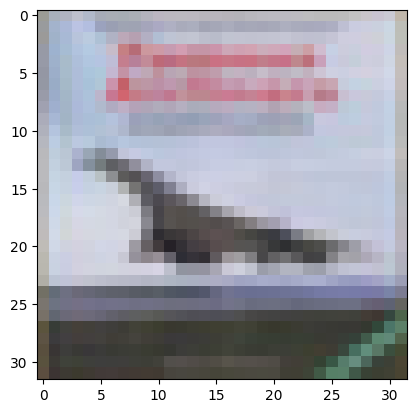

In [102]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model))

Label: automobile , Predicted: automobile


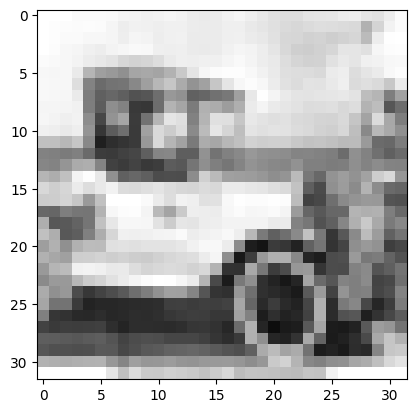

In [103]:
img, label = test_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model))

Label: frog , Predicted: frog


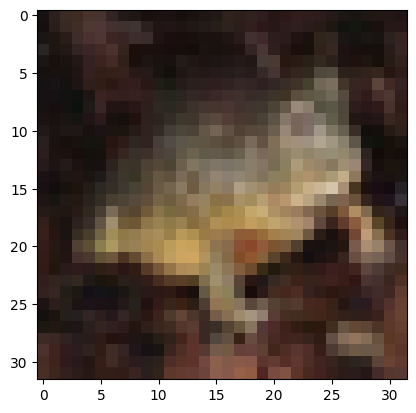

In [104]:
img, label = test_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model))

Label: airplane , Predicted: airplane


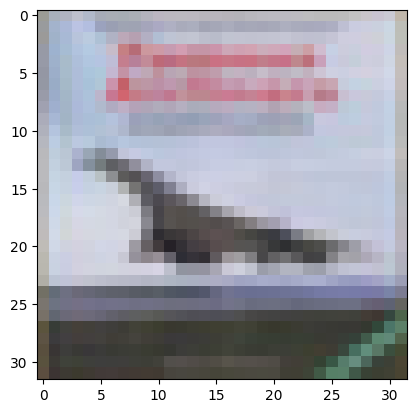

In [105]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model1))

Label: airplane , Predicted: airplane


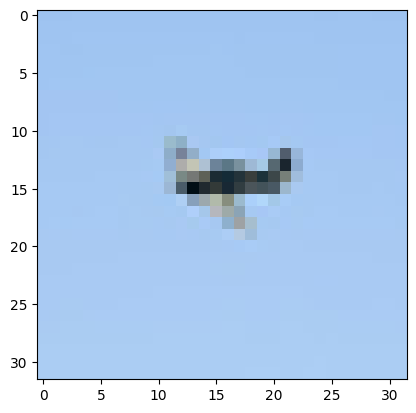

In [106]:
img, label = test_ds[50]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model1))

Label: dog , Predicted: cat


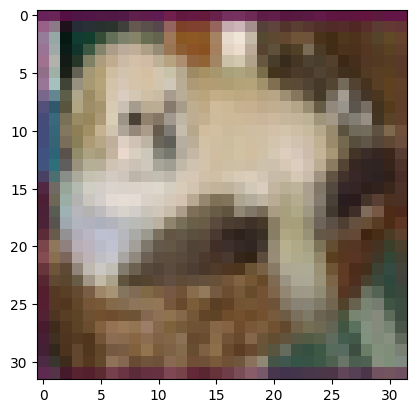

In [107]:
img, label = test_ds[5438]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model1))

Label: dog , Predicted: dog


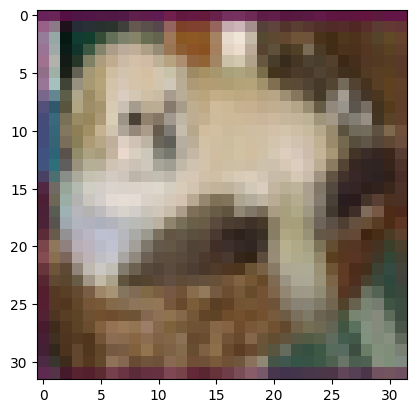

In [110]:
img, label = test_ds[5438]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model3))

Label: dog , Predicted: dog


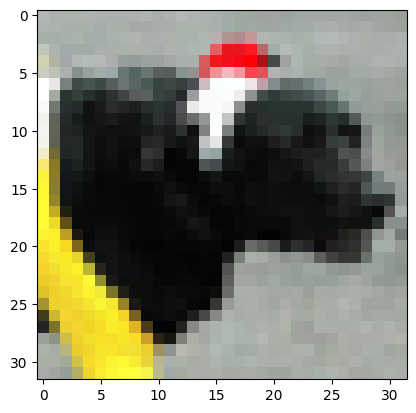

In [111]:
img, label = test_ds[5431]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, test_model2))

In [113]:
result1 = test_evaluate(test_model,test_dl)
result1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'test_loss': 0.8261802792549133, 'test_acc': 0.7530273199081421}

In [114]:
result2 = test_evaluate(test_model1,test_dl)
result2

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'test_loss': 1.0438687801361084, 'test_acc': 0.7725585699081421}

In [116]:
result3 = test_evaluate(test_model2,test_dl)
result3

{'test_loss': 1.2684935331344604, 'test_acc': 0.672070324420929}

In [118]:
result4 = test_evaluate(test_model3,test_dl)
result4

{'test_loss': 1.0187275409698486, 'test_acc': 0.650585949420929}